# 🏛️ Assignment 05 – Population Analysis by Sex and Age

This notebook analyses population data by age and sex in Ireland, computing weighted descriptive statistics — including mean, median, and standard deviation — using official CSO census data.


### 📍 Task A: Weighted Age Analysis by Sex

This task focuses on comparing age distributions between males and females across Ireland. It includes:

- 📊 Weighted mean age by sex
- 📐 Difference in age distributions between sexes
- 🚫 No regional breakdown is required for this part

The notebook demonstrates how to clean, transform, and analyse demographic data using Python and pandas, with an emphasis on clarity, reproducibility, and pedagogical structure.

## ⚙️ Setup: Imports, Configuration, and Directory Paths

This section loads all essential Python libraries used throughout the notebook for data analysis and visualisation. It also defines global configuration constants and prepares output directories for saving plots and processed data.

### ✅ Libraries Used
- `pandas` – for structured data manipulation  
- `numpy` – for numerical operations and statistics  
- `matplotlib` – for plotting and visualisation  
- `IPython.display` – for clean output rendering in notebooks  
- `pathlib` – for consistent and portable file path handling  
- `os` – for interacting with the operating system

### 🛠️ Configuration Constants
- `OUTPUT_DPI`: Controls resolution of saved figures  
- `DEFAULT_FIGSIZE`: Sets default plot size  
- `KDE_BW_MULTIPLIER`: Bandwidth multiplier for KDE smoothing

### 📁 Directory Setup
- `plots/`: Stores visual outputs  
- `data/`: Stores input datasets  
- All paths are defined using `Path` for cross-platform compatibility


In [1]:
# 📦 Essential imports for data analysis and visualisation
import pandas as pd                  # Structured data manipulation (DataFrames)
import numpy as np                   # Numerical operations and statistics
import os                            # OS-level file and path handling
import matplotlib.pyplot as plt      # Plotting and visualisation
from matplotlib.container import BarContainer  # For accessing individual bars in bar plots
from IPython.display import display  # Clean display of DataFrames in Jupyter
from pathlib import Path             # Cross-platform file path handling

# 📌 Global configuration constants
OUTPUT_DPI = 150                     # Resolution of saved figures (higher = sharper)
DEFAULT_FIGSIZE = (9, 5)            # Default plot size for consistency
KDE_BW_MULTIPLIER = 1.0             # Bandwidth multiplier for KDE smoothing

# 📁 Output directory for saving plots (relative to root)
SAVED_PLOTS_DIR = Path('plots').resolve()
SAVED_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# 📂 Data directory for loading input files (relative to root)
DATA_DIR = Path('data').resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

# 🧭 Legacy alias for backward compatibility
DATADIR = DATA_DIR


## 🧰 Notebook Loader & Helper Functions

This section defines a suite of modular helper functions used throughout the notebook to support clarity, reusability, and reviewer understanding. Instead of repeating logic in each analysis cell, these helpers centralise common tasks such as:

- 📤 Saving and displaying plots with consistent resolution and layout  
- 📁 Loading data files using robust path handling and fallback logic  
- 📐 Performing statistical calculations like weighted mean and standard deviation  
- 📊 Generating visualisations including KDE plots and annotated bar charts  
- 📌 Displaying compact previews of top age rows by sex  
- 🗺️ Building tidy CSVs that include administrative county breakdowns  

Each helper is documented with its purpose, rationale, and links to relevant official documentation. This structure ensures the notebook remains clean, interpretable, and easy to maintain — especially for reviewers, students, or collaborators who want to understand or reuse the logic.


In [2]:
# Helper functions: plotting, loaders, and computation (keeps notebook cells concise)
# These functions assume the top-of-notebook imports and constants (plt, pd, np, OUTPUT_DPI, DEFAULT_FIGSIZE, KDE_BW_MULTIPLIER, SAVED_PLOTS_DIR, DATA_DIR)

# ---------- 📤 Utility function for saving and displaying plots ----------

from pathlib import Path as _Path
import re as _re

def save_and_show(out_fp=None, dpi=OUTPUT_DPI):
    """
    Saves the current matplotlib figure to disk (if a file path is provided) and displays it.
    """
    try:
        if out_fp:
            p = _Path(out_fp)
            p.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(p, dpi=dpi, bbox_inches='tight')
            print(f"✅ Saved figure to: {p.resolve()}")
    except Exception as e:
        print(f"⚠️ Could not save figure to {out_fp}: {e}")
    plt.show()

# ---------- 📁 I/O / Loader Helpers ----------

def load_pivot_from_csv(fp):
    """
    Loads a CSV file into a DataFrame, cleans the index to ensure numeric sorting.
    """
    fp = _Path(fp)
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.Index(pd.to_numeric(df.index.to_series(), errors='coerce').fillna(0).astype(int))
    return df.sort_index()

# ---------- 📐 Statistical Computation Helper ----------

def compute_weighted_mean_std(pivot):
    """
    Computes weighted mean and standard deviation of age for each sex group.
    Returns a DataFrame with total population, weighted mean age, and weighted std age.
    """
    results = []
    for sex in pivot.columns:
        weights = pivot[sex].fillna(0).astype(float)
        ages = pivot.index.astype(float)
        total = weights.sum()

        if total > 0:
            wmean = np.average(ages, weights=weights)
            wvar = np.average((ages - wmean) ** 2, weights=weights)
            wstd = np.sqrt(wvar)
        else:
            wmean, wstd = np.nan, np.nan

        results.append((sex, int(total), wmean, wstd))

    df = pd.DataFrame(results, columns=[
        'sex', 'total_population', 'weighted_mean_age', 'weighted_std_age'
    ]).set_index('sex')

    # Ensure numeric types
    df = df.astype({
        'total_population': 'int',
        'weighted_mean_age': 'float',
        'weighted_std_age': 'float'
    })

    return df

def compute_weighted_median(pivot):
    """
    Computes the weighted median age for each sex group.
    Returns a DataFrame with weighted median age by sex.
    """
    median_results = []
    for sex in pivot.columns:
        weights = pivot[sex].fillna(0).astype(float)
        ages = pivot.index.astype(float)

        if weights.sum() > 0:
            cutoff = weights.sum() / 2.0
            cumsum = weights.cumsum()
            wmedian = ages[cumsum >= cutoff][0] if (cumsum >= cutoff).any() else np.nan
        else:
            wmedian = np.nan

        median_results.append((sex, wmedian))

    return pd.DataFrame(median_results, columns=['sex', 'weighted_median_age']).set_index('sex')


# ---------- 📊 Plotting Helpers (Parametric and KDE) ----------

def plot_parametric_bell(df_stats, out_fp=None, figsize=DEFAULT_FIGSIZE):
    """
    Plots approximate normal (bell) curves for each sex group using weighted mean and std.
    """
    if df_stats is None or df_stats.empty:
        raise ValueError("df_stats is empty; provide a DataFrame with mean/std rows")

    plt.figure(figsize=figsize)
    x_min, x_max = None, None

    for sex in df_stats.index:
        mu = df_stats.at[sex, 'weighted_mean_age']
        sigma = df_stats.at[sex, 'weighted_std_age']

        try:
            mu = float(mu)
            sigma = float(sigma)
        except Exception:
            print(f"⚠️ Skipping {sex}: mu/sigma not convertible to float (mu={mu}, sigma={sigma})")
            continue

        if not (np.isfinite(mu) and np.isfinite(sigma) and sigma > 0):
            print(f"⚠️ Skipping {sex}: invalid mu/sigma (mu={mu}, sigma={sigma})")
            continue

        span = max(4 * sigma, 10)
        x = np.linspace(mu - span, mu + span, 400)
        y = (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

        plt.plot(x, y, label=f"{sex} (μ={mu:.2f}, σ={sigma:.2f})")
        x_min = x.min() if x_min is None else min(x_min, x.min())
        x_max = x.max() if x_max is None else max(x_max, x.max())

    plt.title("Approximate Normal (Bell) Curves by Sex")
    plt.xlabel("Age (years)")
    plt.ylabel("Density (approx.)")
    if x_min is not None and x_max is not None:
        plt.xlim(x_min, x_max)
    plt.legend()
    plt.grid(alpha=0.3)
    save_and_show(out_fp)

def compute_and_plot_kde(pivot, out_fp=None, figsize=DEFAULT_FIGSIZE, xgrid=None, bw_multiplier=KDE_BW_MULTIPLIER):
    """
    Computes and plots weighted KDEs for each sex group using actual population counts.
    Returns the x-grid and a dictionary of density curves.
    """
    if pivot is None or pivot.empty:
        raise ValueError("pivot is empty; provide a valid DataFrame")

    pivot.index = pd.to_numeric(pivot.index, errors='coerce').fillna(0).astype(float)
    pivot = pivot.sort_index()
    x_min, x_max = pivot.index.min(), pivot.index.max()

    if xgrid is None:
        xgrid = np.linspace(x_min, x_max, 800)

    plt.figure(figsize=figsize)
    densities = {}

    for sex in pivot.columns:
        weights = pivot[sex].fillna(0).astype(float).to_numpy()
        ages = pivot.index.to_numpy()
        total = weights.sum()

        if total <= 0:
            print(f"⚠️ Skipping {sex}: no data")
            continue

        wmean = np.sum(weights * ages) / total
        wvar = np.sum(weights * (ages - wmean) ** 2) / total
        wstd = np.sqrt(wvar) if np.isfinite(wvar) and wvar > 0 else max(1.0, np.std(ages))

        bw = bw_multiplier * (1.06 * wstd * total ** (-1 / 5) if total > 1 else max(1.0, wstd))
        bw = max(bw, 0.5)

        X = xgrid[:, None]
        A = ages[None, :]
        Z = (X - A) / bw
        kernel = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * Z ** 2)
        density = (kernel * weights[None, :]).sum(axis=1) / (total * bw)

        densities[sex] = density
        plt.plot(xgrid, density, label=f"{sex} (KDE, bw={bw:.2f})")

    plt.title("Weighted KDE of Age by Sex (using actual counts)")
    plt.xlabel("Age (years)")
    plt.ylabel("Estimated density")
    plt.grid(alpha=0.25)
    plt.legend()
    save_and_show(out_fp)

    return xgrid, densities


# ---------- 📌 Display helper: show top-N ages for each sex ----------

def display_top_n_by_sex(pivot, n=10, sexes=None):
    """
    Displays the top-N age groups by population count for each specified sex.
    Returns the last displayed DataFrame (useful for inspection or testing).
    """
    if pivot is None or pivot.empty:
        print("⚠️ Pivot table is empty or not provided.")
        return pd.DataFrame()

    p = pivot.copy()
    p.index = pd.to_numeric(p.index, errors='coerce').fillna(0).astype(int)
    p = p.sort_index()

    if sexes is None:
        sexes = ['Female', 'Male']
    sexes = [s for s in sexes if s in p.columns]

    if not sexes:
        print("⚠️ No matching sex columns found in pivot.")
        return pd.DataFrame()

    last_df = pd.DataFrame()
    for sex in sexes:
        s = p[sex].fillna(0).astype(int)
        top = s.sort_values(ascending=False).head(n)
        df_top = pd.DataFrame({f'{sex}_count': top.values}, index=top.index)

        try:
            display(pd.DataFrame([f"--- Top {n} ages for {sex} ---"]))
        except Exception:
            print(f"--- Top {n} ages for {sex} ---")

        try:
            display(df_top)
        except Exception:
            print(df_top.to_string())

        last_df = df_top

    return last_df


# ---------- 🗺️ Helper: build age-difference CSV including Administrative Counties ----------

def build_age_difference_with_region(raw_df=None, raw_csv_path=None, out_path=None, region_col='Administrative Counties'):
    """
    Builds and saves a tidy CSV with exact headers:
    age, female, male, difference, Administrative Counties.

    Accepts either a raw DataFrame or a CSV path.
    Automatically detects age, sex, value, and region columns if not explicitly provided.
    """
    # Load raw data
    if raw_df is None:
        raw_csv_path = _Path(raw_csv_path) if raw_csv_path else DATA_DIR / 'assignment05_population_for_analysis.csv'
        if not raw_csv_path.exists():
            raise FileNotFoundError(f"Raw population CSV not found: {raw_csv_path}")
        raw = pd.read_csv(raw_csv_path)
    else:
        raw = raw_df.copy()

    # Detect age column
    if 'Single Year of Age' in raw.columns:
        age_col = 'Single Year of Age'
    else:
        poss = [c for c in raw.columns if _re.search(r'(^|\W)age(\W|$)', c, _re.I)]
        if not poss:
            raise ValueError("No age-like column found in raw data")
        age_col = poss[0]

    # Clean age values
    if 'All ages' in raw[age_col].unique():
        raw = raw[raw[age_col] != 'All ages']
    raw[age_col] = raw[age_col].astype(str).str.replace('Under 1 year', '0')
    raw[age_col] = raw[age_col].str.replace(r'\D', '', regex=True)
    raw[age_col] = pd.to_numeric(raw[age_col], errors='coerce').fillna(-1).astype(int)

    # Filter by sex
    if 'Sex' not in raw.columns:
        raise ValueError("No Sex column found in raw data")
    raw = raw[raw['Sex'].isin(['Male', 'Female'])]

    # Detect value column
    if 'VALUE' in raw.columns:
        value_col = 'VALUE'
    else:
        val_cands = [c for c in raw.columns if _re.search(r'value|count|pop', c, _re.I)]
        if not val_cands:
            raise ValueError("No value/count column found in raw data")
        value_col = val_cands[0]

    # Detect region column
    if region_col not in raw.columns:
        candidates = [c for c in raw.columns if _re.search(r'county|region|administr|area|location|geog', c, _re.I)]
        detected = next((c for c in candidates if c), None)
        if not detected:
            for name in ['Administrative Counties', 'Administrative County', 'Region', 'County']:
                if name in raw.columns:
                    detected = name
                    break
        if not detected:
            raise ValueError("Could not find a region-like column in the raw data")
        region_src_col = detected
    else:
        region_src_col = region_col

    # Group and pivot
    grp = raw.groupby([age_col, region_src_col, 'Sex'])[value_col].sum().reset_index()
    pivot = grp.pivot_table(index=[age_col, region_src_col], columns='Sex', values=value_col, fill_value=0).reset_index()

    # Ensure Male/Female columns
    pivot['Male'] = pivot.get('Male', 0)
    pivot['Female'] = pivot.get('Female', 0)

    # Build final DataFrame
    df_region = pd.DataFrame({
        'age': pivot[age_col].astype(int),
        'female': pivot['Female'].astype(int),
        'male': pivot['Male'].astype(int),
        'Administrative Counties': pivot[region_src_col].astype(str)
    })
    df_region['difference'] = df_region['male'] - df_region['female']
    df_region = df_region[['age', 'female', 'male', 'difference', 'Administrative Counties']]

    # Save CSV
    out_path = _Path(out_path) if out_path else DATA_DIR / 'assignment05_age_difference_by_sex_with_region.csv'
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_region.to_csv(out_path, index=False)

    try:
        print(f"✅ Saved age-by-region difference CSV to: {out_path.resolve()}")
    except Exception:
        print(f"✅ Saved age-by-region difference CSV to: {out_path}")

    return df_region


### 📂 Notebook Setup: Paths and Display Options

This section prepares the notebook environment by configuring file paths and display settings.

- **Working Directory**: Captures the current working directory to support relative path resolution.
- **Data Directory**: Ensures the `data/` folder exists for saving outputs such as CSV files and processed datasets.
- **Filename Setup**: Defines the canonical filename `assignment05_population_for_analysis.csv` and constructs its full path using `Path`.
- **Display Preferences**: Limits the number of rows shown in DataFrame outputs to avoid overwhelming the notebook interface.
- **Path Confirmation**: Prints resolved paths for transparency and debugging, especially useful when working across different machines or environments.


In [3]:
# ---------- 📂 Notebook Setup: Paths and Display Options ----------

# Derive the current working directory (useful for relative path resolution)
notebook_dir = os.getcwd()

# Ensure the data output directory exists on disk
# This is important for saving plots, outputs, or derived files
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Define the canonical filename and its full path for reading/writing data
FILENAME = "assignment05_population_for_analysis.csv"
FULLPATH = DATA_DIR / FILENAME  # Combines directory and filename using Path

# Set notebook display preferences for DataFrames
# Limits the number of rows shown to avoid overwhelming output
pd.options.display.max_rows = 20

# Confirm paths for transparency and debugging
print("Base data directory:", str(DATA_DIR))
print("Using FULLPATH for pivot/read:", str(FULLPATH))


Base data directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data
Using FULLPATH for pivot/read: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment05_population_for_analysis.csv


### ✅ Run This Notebook: Quick Checklist

Please run all cells in order. If you restart the kernel, re-run the setup and data preparation steps below before executing any analysis or plotting cells.

#### 🔁 Required Setup Steps
1. **Initial setup** — import libraries and define paths (top of notebook)  
2. **Load dataset** — fetch and save `assignment05_population_for_analysis.csv` from the CSO API  
3. **Clean data** — convert age labels and filter to male/female records  
4. **Create pivot table** — generate `df_anal` and save `assignment05_weighted_stats_by_sex.csv` (required for KDE)  
5. **Compute weighted statistics** — produce `assignment05_weighted_mean_std_by_sex.csv` (required for bell curve)  
6. **Generate plots** — bell curve and KDE visualisations saved as PNGs in the `plots/` directory

#### 📁 Expected Output Files

**Saved in `data/`:**
- `assignment05_population_for_analysis.csv`  
- `assignment05_weighted_stats_by_sex.csv`  
- `assignment05_weighted_mean_std_by_sex.csv`  
- `assignment05_age_difference_by_sex.csv`  
- `assignment05_age_difference_by_sex_with_region.csv`  

**Saved in `plots/`:**
- `assignment05-age-bell-curve.png`  
- `assignment05-age-kde.png`

### Load Dataset

In [4]:
# ---------- 📥 Fetch and Save Population Data from CSO API ----------

# Define the API endpoint for the CSO population dataset (FY006A)
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en"
print("Fetching raw data from URL:", url)

# Read the CSV-formatted dataset directly from the API
df = pd.read_csv(url)

# Ensure the data directory exists before saving
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Define the full output path
FILENAME = "assignment05_population_for_analysis.csv"
FULLPATH = DATA_DIR / FILENAME

# Save the raw dataset
df.to_csv(FULLPATH, index=False)
print("✅ Saved raw population data to:", str(FULLPATH.resolve()))

# 🧾 Verify the saved file and inspect columns
saved_df = pd.read_csv(FULLPATH)
try:
    display(saved_df.tail(3))
except Exception:
    print("⚠️ Could not display tail of raw data; file saved at:", str(FULLPATH.resolve()))


Fetching raw data from URL: https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en
✅ Saved raw population data to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment05_population_for_analysis.csv


,STATISTIC,Statistic Label,TLIST(A1),CensusYear,C02199V02655,Sex,C02076V03371,Single Year of Age,C03789V04537,Administrative Counties,UNIT,VALUE
9789,FY006AC01,Population,2022,2022,2,Female,650,100 years and over,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,12
9790,FY006AC01,Population,2022,2022,2,Female,650,100 years and over,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,31
9791,FY006AC01,Population,2022,2022,2,Female,650,100 years and over,2ae19629-1495-13a3-e055-000000000001,Monaghan County Council,Number,7


### 🧾 View Column Names

This section displays all column headers from the loaded dataset, numbered for easy reference.  
It helps verify the structure of the data and identify relevant fields for filtering, grouping, or visualisation.


In [5]:
# 🔍 Display column headers with numbering
headers = saved_df.columns.tolist()
for i, col in enumerate(headers, 1):
    print(f"{i}. {col}")


1. STATISTIC
2. Statistic Label
3. TLIST(A1)
4. CensusYear
5. C02199V02655
6. Sex
7. C02076V03371
8. Single Year of Age
9. C03789V04537
10. Administrative Counties
11. UNIT
12. VALUE


### 🧹 PART 1 Load and Clean Raw Population Data

This section reads the saved population dataset and prepares it for analysis by performing the following steps:

- **Load CSV**: Reads the raw file from disk using the defined `FULLPATH`.
- **Drop unnecessary columns**: Removes metadata and unused fields to simplify the dataset.
- **Filter by sex**: Keeps only rows where `Sex` is either "Male" or "Female".
- **Clean age labels**: Removes non-numeric entries like "All ages" and converts "Under 1 year" to `0`.
- **Convert to numeric**: Ensures `Single Year of Age` and `VALUE` columns are stored as integers.
- **Inspect structure**: Displays column types and memory usage using `df.info()`.

This cleaned dataset forms the basis for pivoting, statistical computation, and visualisation in later steps.


In [6]:
# ---------- 📥 Load and Clean Raw Population Data ----------

# Read the raw dataset
print("Reading raw file from:", os.path.abspath(FULLPATH))
df = pd.read_csv(FULLPATH)

# Drop columns not needed for analysis
drop_cols = [
    'STATISTIC', 'Statistic Label', 'TLIST(A1)', 'CensusYear',
    'C02199V02655', 'C02076V03371', 'C03789V04537', 'Administrative Counties', 'UNIT'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Keep only Male and Female rows
df = df[df['Sex'].isin(['Male', 'Female'])]

# Clean age labels
df = df[df['Single Year of Age'] != 'All ages']
df['Single Year of Age'] = df['Single Year of Age'].str.replace('Under 1 year', '0')
df['Single Year of Age'] = df['Single Year of Age'].str.replace(r'\D', '', regex=True)

# Convert columns to numeric
df['Single Year of Age'] = df['Single Year of Age'].astype(int)
df['VALUE'] = df['VALUE'].astype(int)

# Display structure
df.info()


Reading raw file from: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment05_population_for_analysis.csv
<class 'pandas.core.frame.DataFrame'>
Index: 6464 entries, 3296 to 9791
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Sex                 6464 non-null   object
 1   Single Year of Age  6464 non-null   int64 
 2   VALUE               6464 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 202.0+ KB


### 📈 Create Pivot Table: Age vs Sex

This section transforms the cleaned dataset into a pivot table that summarises population counts by age and sex.

- **Standardises sex labels** to ensure consistent column names.
- **Creates a pivot table** with age as the index and sex groups as columns.
- **Sorts the index** to maintain chronological order.
- **Saves the pivot** to `assignment05_weighted_stats_by_sex.csv` for reuse in later analysis.
- **Displays a preview** of the resulting table to verify structure and values.


In [7]:
# ---------- 📈 Pivot Table: Age vs Sex ----------

# Standardise sex labels
df['Sex'] = df['Sex'].str.strip().str.title()

# Create pivot table: age as rows, sex as columns, population counts as values
df_anal = pd.pivot_table(df, values='VALUE', index='Single Year of Age', columns='Sex')
df_anal = df_anal.sort_index()

# Save pivot table
output_path = DATA_DIR / "assignment05_weighted_stats_by_sex.csv"
df_anal.to_csv(output_path)
print("✅ Saved pivot table to:", str(output_path.resolve()))

# Display preview
display(df_anal.head())


✅ Saved pivot table to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment05_weighted_stats_by_sex.csv


Sex,Female,Male
Single Year of Age,,
0,1761.6250,1850.6250
1,1721.5625,1804.6875
2,1810.8750,1889.7500
3,1842.6875,1937.5625
4,1863.6875,1980.3750


In [8]:
# ---------- ✅ Sanity Check: Pivot Table Validation ----------

# Confirm pivot table exists
if 'df_anal' in globals():
    pivot = df_anal.copy()

    print("✅ Pivot found with", pivot.shape[0], "age rows and", pivot.shape[1], "columns")
    display(pivot.head())

    # Show age range
    print("Age range:", pivot.index.min(), "to", pivot.index.max())

    # Confirm expected columns
    expected = ['Male', 'Female']
    missing = [col for col in expected if col not in pivot.columns]
    if missing:
        print("⚠️ Missing columns:", missing)
    else:
        print("✅ Pivot contains expected sex columns:", expected)
else:
    print("❌ Pivot table `df_anal` not found. Please run the pivot cell first.")


✅ Pivot found with 101 age rows and 2 columns


Sex,Female,Male
Single Year of Age,,
0,1761.6250,1850.6250
1,1721.5625,1804.6875
2,1810.8750,1889.7500
3,1842.6875,1937.5625
4,1863.6875,1980.3750


Age range: 0 to 100
✅ Pivot contains expected sex columns: ['Male', 'Female']


## 🧮 Weighted Mean Age by Sex (Using NumPy)

This section calculates the weighted mean and standard deviation of age for each sex group using population counts as weights.  
These metrics provide a more accurate representation of central tendency and spread than simple averages.

### 📊 Weighted Mean Explained
The weighted mean adjusts each value’s contribution based on its assigned weight — in this case, population count.  
This ensures that age groups with larger populations influence the average more than smaller ones.  
*See README for further explanation.*

### 📚 References
- [NumPy: `average()` function](https://numpy.org/doc/stable/reference/generated/numpy.average.html)  
- [Pandas: `DataFrame.mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html)  
- [Pandas: `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)

### 🔧 Process Overview
- Load the pivot table from CSV
- Loop through each sex group and apply weighted formulas
- Save the resulting summary to `assignment05_weighted_mean_std_by_sex.csv`
- Display the final DataFrame for inspection

In [9]:
# ---------- 🧮 Compute and Save Weighted Mean & Standard Deviation ----------

# Load pivot table
df_anal = pd.read_csv(output_path, index_col=0)

# Compute weighted mean and standard deviation
results = []
ages = df_anal.index.to_numpy(dtype=float)

for sex in df_anal.columns:
    weights = df_anal[sex].fillna(0).astype(float)

    if weights.sum() > 0:
        wmean = np.average(ages, weights=weights)
        wstd = np.sqrt(np.average((ages - wmean) ** 2, weights=weights))
        total = int(weights.sum())
    else:
        wmean, wstd, total = float('nan'), float('nan'), 0

    results.append((sex, total, wmean, wstd))

# Create and save summary table
mean_std_df = pd.DataFrame(
    results,
    columns=['sex', 'total_population', 'weighted_mean_age', 'weighted_std_age']
).set_index('sex')
mean_std_df.to_csv(DATA_DIR / 'assignment05_weighted_mean_std_by_sex.csv')

# Display result
display(mean_std_df)


,total_population,weighted_mean_age,weighted_std_age
sex,,,
Female,162786,38.939796,22.998990
Male,159034,37.739448,22.671204


# Normal Distribution

![XKCD Comic](https://imgs.xkcd.com/comics/normal_distribution_2x.png)

This comic image humorously illustrates the concept of a normal distribution, highlighting the common misconception that data should always fit a perfect bell curve. In reality, many datasets exhibit variations and deviations from this idealized shape, reminding us that statistical distributions can be complex and diverse.

source: [XKCD Comic on Normal Distribution](https://xkcd.com/221/)

### 📈 Bell-Curve Plot Using Weighted Mean & Standard Deviation

This section plots an approximate normal (Gaussian) density curve for each sex using the weighted mean (μ) and standard deviation (σ) previously computed and saved to `assignment05_weighted_mean_std_by_sex.csv`.

These parametric curves offer a simplified visual comparison between male and female age distributions.  
However, real-world age data is often skewed or multi-modal, so this plot should be interpreted as a stylised summary.

To complement this, the next cell generates a **weighted KDE** (Kernel Density Estimate) using actual single-year age counts from the pivot table (`df_anal` or `assignment05_weighted_stats_by_sex.csv`).  
This produces a smoothed, data-driven density plot saved to `assignment05-age-kde.png`.

### 🔁 Execution Order
1. Run the **pivot cell** to create `df_anal`
2. Run the **weighted mean/std cell** to save `assignment05_weighted_mean_std_by_sex.csv`
3. Run the **plotting cells** to generate:
   - `assignment05-age-bell-curve.png` (parametric normal curves)
   - `assignment05-age-kde.png` (data-driven KDE)

Use the KDE for a realistic shape derived from actual counts.  
Use the bell-curve for a concise parametric comparison.


✅ Saved figure to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment05-age-bell-curve.png


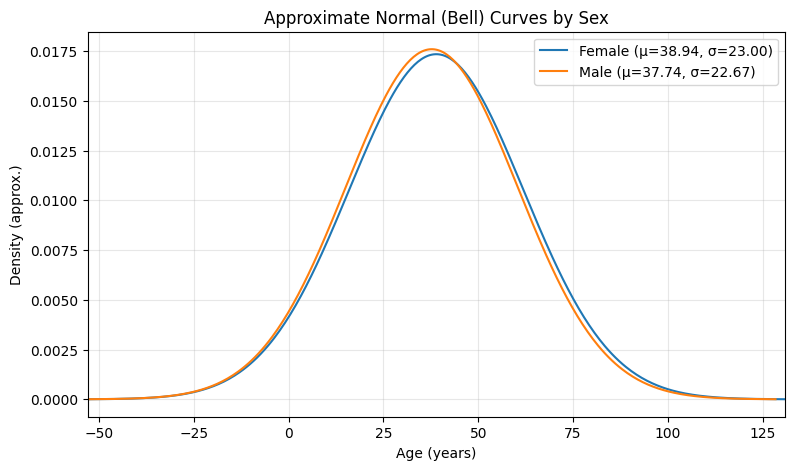

In [10]:
# ---------- 📈 Plot Parametric Bell Curves Using Weighted Mean & Standard Deviation ----------

# Use the summary statistics DataFrame
df_stats = mean_std_df.copy()

# Plot and save bell curves
out_fp = SAVED_PLOTS_DIR / 'assignment05-age-bell-curve.png'
plot_parametric_bell(df_stats, out_fp=out_fp)


### 🔍 Key Observations in Bell-Curve Plot

The bell-curve visualises a Normal (Gaussian) distribution for each sex using the weighted mean (μ) and standard deviation (σ) computed earlier.

- Both curves **peak near the same age**, indicating similar mean values.
- The spread (σ ≈ 23) is also similar, so the distributions **largely overlap**.
- Minor differences (e.g. slight horizontal shift or peak height) reflect small variations in mean and standard deviation.

This suggests that men and women have a **comparable age structure** in this dataset.

---

### 🧠 Why This Matters — and the XKCD Joke

The bell-curve is a tidy parametric summary: it assumes the data are **symmetric and single-peaked** — the idealised “normal” shape shown in the comic.

The [XKCD comic](https://xkcd.com/221/) reminds us that **real data are often messy** — skewed, multi-modal, or irregular.  
That’s why we also inspect the KDE (Kernel Density Estimate), which is **data-driven** and reflects the actual shape of the distribution.

In this notebook, the KDE and bell-curve are quite similar, so the Normal approximation is reasonable — but we still use KDE to catch any hidden skew or extra bumps.

---

### 📚 References and Resources

- [Seaborn `kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) — convenient KDE plotting  
- [Normal distribution (Wikipedia)](https://en.wikipedia.org/wiki/Normal_distribution) — definition and PDF formula  
- [Weighted mean & variance](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean) — formulas used in this notebook  
- [Weighted median explanation](https://real-statistics.com/descriptive-statistics/measures-central-tendency/weighted-mean-and-median/) — background reading  
- [CSO FY006A dataset](https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en) — raw population data source  


### 📊 Weighted KDE of Age by Sex

This section computes a **weighted Kernel Density Estimate (KDE)** of age for each sex group using actual population counts from the pivot table (`df_anal`).

Unlike the bell-curve, which assumes a normal distribution, KDE is **non-parametric** and reflects the true shape of the data — including skewness, multi-modal peaks, or irregularities.

- Uses single-year age counts as weights
- Applies smoothing via bandwidth adjustment (`KDE_BW_MULTIPLIER`)
- Produces a realistic density curve for each sex
- Saves the plot to `assignment05-age-kde.png` in the `plots/` directory

This visualisation complements the bell-curve by showing how closely the real data follows a normal distribution — or where it diverges.


✅ Saved figure to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment05-age-kde.png


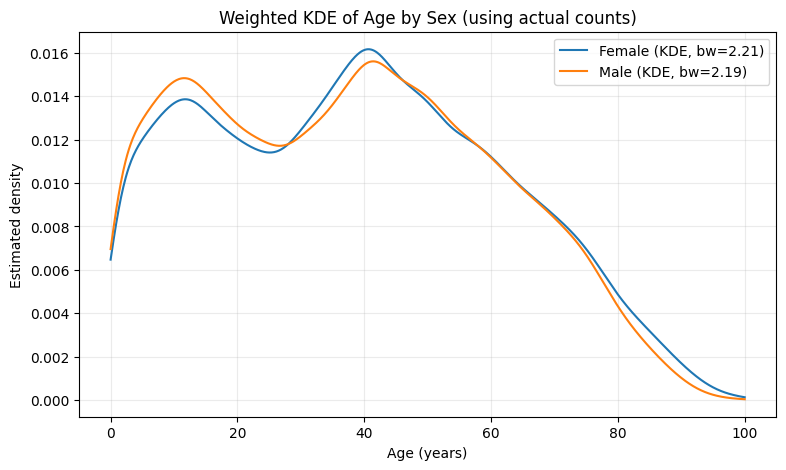


Female KDE preview:


,age,density
0,0.000000,0.006469
1,0.125156,0.006718
2,0.250313,0.006963
3,0.375469,0.007205
4,0.500626,0.007443
5,0.625782,0.007676
6,0.750939,0.007903
7,0.876095,0.008125
8,1.001252,0.008341
9,1.126408,0.008550



Male KDE preview:


,age,density
0,0.000000,0.006954
1,0.125156,0.007224
2,0.250313,0.007490
3,0.375469,0.007752
4,0.500626,0.008009
5,0.625782,0.008261
6,0.750939,0.008508
7,0.876095,0.008747
8,1.001252,0.008980
9,1.126408,0.009206


In [11]:
# ---------- 🔎 KDE Plot: Smoothed Age Density Using Actual Counts ----------

# Use the pivot table
pivot = df_anal.copy()

# Compute and plot KDE
kde_fp = SAVED_PLOTS_DIR / 'assignment05-age-kde.png'
xgrid, densities = compute_and_plot_kde(pivot, out_fp=kde_fp)

# Preview first 10 KDE values per sex
for sex, density in densities.items():
    print(f"\n{sex} KDE preview:")
    preview_df = pd.DataFrame({'age': xgrid[:10], 'density': density[:10]})
    display(preview_df)


### 📊 Key Observations in Weighted KDE of Age by Sex

The KDE plot shows that both sexes have **similar overall age distributions** — the curves largely overlap, indicating comparable population structure between Female and Male groups.

#### 🔍 Notable Features
- **Visible peaks**:
  - A sharp peak in younger ages (e.g. small children)
  - A broader hump around middle ages
- These peaks reflect **common age groups** in the population.
- **Small differences** between the curves (where one line slightly exceeds the other) highlight age ranges where one sex has a relatively higher proportion.

This data-driven KDE offers a realistic view of the age distribution, complementing the bell-curve by revealing subtle asymmetries or multi-modal patterns.

---

### 📚 References and Resources

- [Pandas (data manipulation)](https://pandas.pydata.org/)  
- [NumPy (numerical operations)](https://numpy.org/)  
- [Matplotlib (plotting)](https://matplotlib.org/)  
- [Kernel Density Estimation (concept)](https://en.wikipedia.org/wiki/Kernel_density_estimation)  
- [Bandwidth selection (Scott’s & Silverman’s rules)](https://en.wikipedia.org/wiki/Kernel_density_estimation#Choice_of_bandwidth)  
- [SciPy KDE examples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)


## 🧮 Weighted Median and Standard Deviation (by Sex)

When analysing age distributions across sexes (e.g. Male and Female), it’s important to understand not just the average age, but also the **central tendency** (median) and **spread** (standard deviation) — especially when population counts vary across age groups.

### 🎯 Weighted Median Explained

The **weighted median** is the age at which half of the weighted population is younger and half is older.  
It accounts for the number of individuals at each age, making it more robust than the mean when the data is skewed.  
*See README for further explanation.*

### 📚 References and Resources
- [NumPy `average()` method](https://numpy.org/doc/stable/reference/generated/numpy.average.html) — used for weighted means and variance  
- [Real Statistics: Weighted Median](https://real-statistics.com/descriptive-statistics/measures-central-tendency/weighted-mean-and-median/) — step-by-step logic using cumulative weights  
- [pandas Series API](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) — `.median()` method (unweighted only)


### 🔧 Compute Weighted Median Age by Sex

What this Cell Does
- Iterates through each sex group in the pivot table (`df_anal`)
- Computes the weighted median using cumulative weights
- Saves the result to `assignment05_weighted_median_by_sex.csv`
- Displays the final DataFrame for inspection

In [12]:
# ---------- 🧮 Compute Weighted Median Age by Sex ----------

# Calculate weighted median age for each sex
median_results = []
for sex in df_anal.columns:
    weights = df_anal[sex].fillna(0).astype(float)
    ages = df_anal.index.astype(float)

    if weights.sum() > 0:
        cutoff = weights.sum() / 2
        cumsum = weights.cumsum()
        wmedian = ages[cumsum >= cutoff][0]
    else:
        wmedian = np.nan

    median_results.append((sex, wmedian))

# Create and save results
median_df = pd.DataFrame(median_results, columns=['sex', 'weighted_median_age']).set_index('sex')
median_df.to_csv(DATA_DIR / 'assignment05_weighted_median_by_sex.csv')

# Display result
display(median_df)


,weighted_median_age
sex,
Female,39.0
Male,38.0


### 📊 Weighted Standard Deviation

The **weighted standard deviation** measures how spread out the ages are, accounting for population size at each age. *see README for further explanation.*


- [NumPy `average()` method](https://numpy.org/doc/stable/reference/generated/numpy.average.html)  
  Used to compute weighted means and intermediate steps for weighted variance and standard deviation. Supports the `weights` parameter for efficient calculation.

- [Real Statistics: Weighted Mean and Standard Deviation](https://real-statistics.com/descriptive-statistics/measures-central-tendency/weighted-mean-and-median/)  
  Provides formulas and examples for computing weighted standard deviation, including the use of weighted variance as a precursor.

- [pandas Series API](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)  
  pandas supports `.std()` for standard deviation, but does not natively support weighted standard deviation. Custom logic using NumPy or manual weighting is required.


In [13]:
# ---------- 🧮 Compute Weighted Standard Deviation by Sex ----------

# Calculate weighted standard deviation of age for each sex
std_results = []
ages = df_anal.index.to_numpy(dtype=float)

for sex in df_anal.columns:
    weights = df_anal[sex].fillna(0).astype(float)

    if weights.sum() > 0:
        wmean = np.average(ages, weights=weights)
        wstd = np.sqrt(np.average((ages - wmean) ** 2, weights=weights))
    else:
        wstd = np.nan

    std_results.append((sex, wstd))

# Create and save results
std_df = pd.DataFrame(std_results, columns=['sex', 'weighted_std_age']).set_index('sex')
std_df.to_csv(DATA_DIR / 'assignment05_weighted_std_by_sex.csv')

# Display result
display(std_df)


,weighted_std_age
sex,
Female,22.998990
Male,22.671204


### 🔗 Merge and Export Combined Results

This section consolidates key summary statistics — including weighted mean, standard deviation, and median — into a single tidy DataFrame for each sex group.

- Merges `assignment05_weighted_mean_std_by_sex.csv` and `assignment05_weighted_median_by_sex.csv`
- Produces a unified table with total population, weighted mean age, standard deviation, and median age
- Saves the result to `assignment05_age_difference_by_sex.csv` in the `data/` directory

This combined output simplifies downstream analysis and makes it easier to compare age-related metrics across sexes.


In [14]:
# ---------- 📁 Save Weighted Median and Standard Deviation by Sex ----------

# Define output path
ws_path = DATA_DIR / "assignment05_weighted_mean_std_by_sex.csv"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Merge and save
combined_df = median_df.join(std_df)
combined_df.to_csv(ws_path)

# Display result
print("✅ Saved weighted median and std to:", str(ws_path.resolve()))
display(combined_df)


✅ Saved weighted median and std to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment05_weighted_mean_std_by_sex.csv


,weighted_median_age,weighted_std_age
sex,,
Female,39.0,22.998990
Male,38.0,22.671204


### 📊 Weighted Mean Age Difference by Sex — Bar Chart

This section visualises the difference in **weighted mean age** between Male and Female groups using a simple bar chart.

- Highlights the central tendency of each sex group based on population-weighted age
- Uses values from `assignment05_weighted_mean_std_by_sex.csv`
- Provides a clear visual comparison of average age structure
- Saves the chart to `assignment05-age-mean-difference-bar.png` in the `plots/` directory

This plot is useful for quickly spotting any meaningful age gap between sexes, even if the difference is small.


Plotting weighted means (loaded from: df_anal (in-memory) )
✅ Saved mean-age bar plot to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment05-mean-age-bar.png


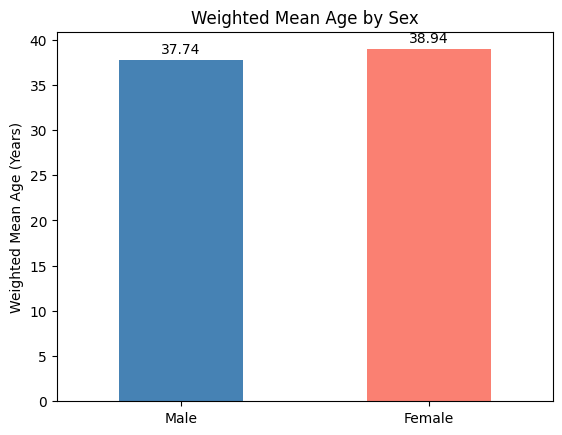

In [15]:
# ---------- 📊 Bar Chart: Weighted Mean Age by Sex ----------

# Prefer pre-computed weighted means from CSV if available
mean_fp = DATA_DIR / 'assignment05_weighted_mean_std_by_sex.csv'
means_series = None
loaded_from = None

# 🧮 Attempt to load weighted means from disk
if mean_fp.exists():
    df_stats = pd.read_csv(mean_fp, index_col=0)
    if 'weighted_mean_age' in df_stats.columns:
        means_series = df_stats['weighted_mean_age'].astype(float)
        loaded_from = str(mean_fp)

# 🔁 Fallback: compute weighted means from in-memory pivot table
if means_series is None and 'df_anal' in globals():
    pivot = df_anal.sort_index()
    means_calc = {}
    for sex in ['Male', 'Female']:
        if sex in pivot.columns:
            w = pivot[sex].fillna(0).astype(float)
            means_calc[sex] = np.average(pivot.index.astype(float), weights=w) if w.sum() > 0 else float('nan')
        else:
            means_calc[sex] = float('nan')
    means_series = pd.Series(means_calc, name='weighted_mean_age')
    loaded_from = 'df_anal (in-memory)'

# 🚫 If no data is available, inform the user
if means_series is None:
    print('No weighted mean data available. Run the mean computation cell (which writes assignment05_weighted_mean_std_by_sex.csv) or create `df_anal` by running the pivot cell.')
else:
    print('Plotting weighted means (loaded from:', loaded_from, ')')

    # 📈 Create bar chart
    ax = means_series.plot(
        kind='bar',
        title='Weighted Mean Age by Sex',
        rot=0,
        color=['steelblue', 'salmon']
    )
    ax.set_ylabel('Weighted Mean Age (Years)')

    # 🏷️ Add value labels to each bar
    for container in ax.containers:
        if not isinstance(container, BarContainer):
            continue
        heights = [patch.get_height() for patch in container]
        labels = [f"{height:.2f}" if not pd.isna(height) else "NaN" for height in heights]
        ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=10)

    # 💾 Save the figure to disk
    plot_fp = SAVED_PLOTS_DIR / 'assignment05-mean-age-bar.png'
    plt.savefig(plot_fp, dpi=150, bbox_inches='tight')
    print('✅ Saved mean-age bar plot to:', str(plot_fp.resolve()))
    plt.show()


### 📊 Age-by-Age Difference Between Sexes

This section computes the difference in population counts between Male and Female for each single-year age group.

- Uses the pivot table `df_anal` created earlier
- Fills missing sex columns with zeros to avoid errors
- Calculates `difference = male − female` and identifies which sex is greater
- Saves the tidy result to `assignment05_age_difference_by_sex.csv` with columns:
  - `age`, `female`, `male`, `difference`, `sex_greater_age_difference`

This output helps highlight age groups with notable imbalances between sexes.


In [16]:
# ---------- 🗃️ Create and Save Age Difference by Sex ----------

# Use the in-memory pivot table
pivot = df_anal.copy()

# Ensure numeric, sorted age index
pivot.index = pivot.index.astype(int)
pivot = pivot.sort_index()

# Extract male and female counts
male_series = pivot.get('Male', pd.Series(0, index=pivot.index)).fillna(0).astype(int)
female_series = pivot.get('Female', pd.Series(0, index=pivot.index)).fillna(0).astype(int)

# Build output DataFrame
df_out = pd.DataFrame({
    'age': pivot.index,
    'female': female_series.values,
    'male': male_series.values
})
df_out['difference'] = df_out['male'] - df_out['female']
df_out['sex_greater_age_difference'] = np.where(
    df_out['male'] > df_out['female'], 'Male',
    np.where(df_out['female'] > df_out['male'], 'Female', 'Equal')
)

# Save to CSV
age_diff_fp = DATA_DIR / "assignment05_age_difference_by_sex.csv"
df_out.to_csv(age_diff_fp, index=False)
print('✅ Saved age-difference CSV to:', str(age_diff_fp.resolve()))

# Display preview
display(df_out.head())


✅ Saved age-difference CSV to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment05_age_difference_by_sex.csv


,age,female,male,difference,sex_greater_age_difference
0,0,1761,1850,89,Male
1,1,1721,1804,83,Male
2,2,1810,1889,79,Male
3,3,1842,1937,95,Male
4,4,1863,1980,117,Male


### References & Exercises

References (short list). For a fuller list see README:
- CSO FY006A data: https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en
- pandas, NumPy, matplotlib documentation (links inline where used)





### 📊 PART 2 Age-Band Sex Comparison (±5 Years)

This section compares Male and Female population counts within a selected age band centered on `target_age` (default = 35).

- Filters ages in `[target_age − 5, target_age + 5]`
- Aggregates total counts for each sex
- Identifies which sex is more represented at each age
- Plots a bar chart and prints a summary
- Saves the output to `assignment05-age-group-35-sex-comparison.png`

Use this to explore age-specific imbalances and visualise local population structure.



✅ Saved figure to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment05-age-group-35-sex-comparison.png


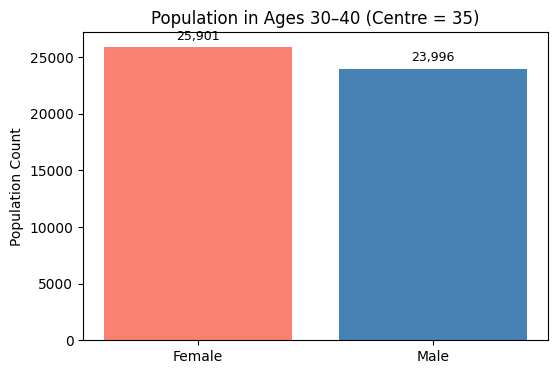

Female = 25,901, Male = 23,996, Diff (M−F) = -1,905, % of Band = -3.82%


,age,female,male,difference,sex_greater_age_difference,majority
30,30,2052,1928,-124,Female,Female
31,31,2106,2014,-92,Female,Female
32,32,2148,2025,-123,Female,Female
33,33,2155,1993,-162,Female,Female
34,34,2267,2070,-197,Female,Female
35,35,2371,2168,-203,Female,Female
36,36,2439,2239,-200,Female,Female
37,37,2449,2276,-173,Female,Female
38,38,2556,2344,-212,Female,Female
39,39,2662,2421,-241,Female,Female


In [17]:
# ---------- ▶️ Age-band Sex Comparison – Enhanced Summary and Visualisation ----------

# Define age band
target_age = 35
band = 5
min_age, max_age = target_age - band, target_age + band

# Load and clean age-difference data
age_df = pd.read_csv(DATA_DIR / 'assignment05_age_difference_by_sex.csv')
age_df['age'] = pd.to_numeric(age_df['age'], errors='coerce').fillna(0).astype(int)

# Filter by age band
band_df = age_df[age_df['age'].between(min_age, max_age)].copy()

# Add majority column
band_df['majority'] = np.where(
    band_df['male'] > band_df['female'], 'Male',
    np.where(band_df['female'] > band_df['male'], 'Female', 'Equal')
)

# Aggregate totals
female_total = band_df['female'].sum()
male_total = band_df['male'].sum()
total = female_total + male_total
diff = male_total - female_total
pct = (diff / total * 100) if total else float('nan')

# Create bar chart
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Female', 'Male'], [female_total, male_total], color=['salmon', 'steelblue'])
ax.set_title(f'Population in Ages {min_age}–{max_age} (Centre = {target_age})')
ax.set_ylabel('Population Count')
ax.bar_label(bars, labels=[f'{female_total:,}', f'{male_total:,}'], padding=3, fontsize=9)

# Save and show
plot_name = f'assignment05-age-group-{target_age}-sex-comparison.png'
save_and_show(SAVED_PLOTS_DIR / plot_name)

# Print summary
print(f'Female = {female_total:,}, Male = {male_total:,}, Diff (M−F) = {diff:,}, % of Band = {pct:.2f}%')

# Display filtered data
display(band_df)


🧠 Interpretation Guidance
“Which sex has the larger population in the selected age band, and by how much?”

In the age band 30–40, females have a larger population than males by a total of 1,905 people, which is approximately 3.82% of the age-band total.

### 🗺️ PART 3 Regional Sex Difference — Top Counties by Age Band

This section identifies which Irish county has the largest population difference between sexes within a selected age band.

- Loads or builds `assignment05_age_difference_by_sex_with_region.csv`
- Filters rows to the target age range and excludes the national total ("Ireland")
- Aggregates Male and Female counts by **Administrative County**
- Computes the **absolute difference** and identifies the majority sex
- Selects the **top 10 counties** with the largest sex gap
- Visualises results using a colour-coded bar chart:
  - 🔵 Blue = Male majority
  - 🌸 Pink = Female majority
- Annotates each bar with the exact difference
- Prints a summary of the county with the largest gap and explains the result

This analysis highlights regional imbalances and helps pinpoint counties with notable sex-based population differences in the selected age band.


C:\Users\eCron\AppData\Local\Temp\ipykernel_18656\3692574518.py:58: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.savefig(out_fp, dpi=150, bbox_inches='tight')


✅ Saved region-difference plot to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment05-age-group-35-region-sex-diff.png


c:\Users\eCron\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


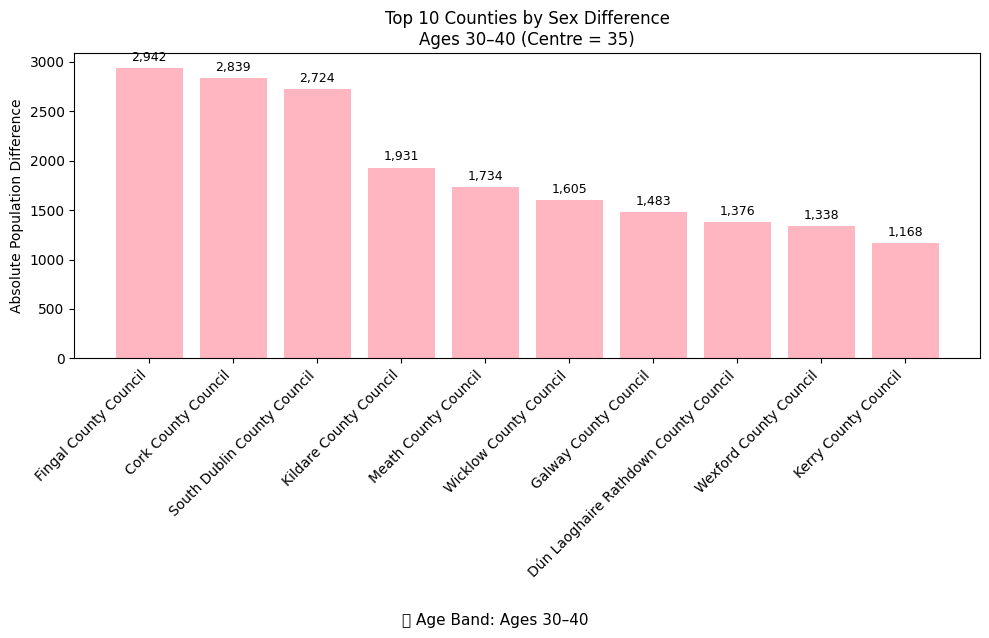

,male,female,difference,majority
Administrative Counties,,,,
Fingal County Council,26150,29092,-2942,Female
Cork County Council,23706,26545,-2839,Female
South Dublin County Council,23637,26361,-2724,Female
Kildare County Council,18671,20602,-1931,Female
Meath County Council,15981,17715,-1734,Female
Wicklow County Council,10338,11943,-1605,Female
Galway County Council,12421,13904,-1483,Female
Dún Laoghaire Rathdown County Council,17074,18450,-1376,Female
Wexford County Council,10824,12162,-1338,Female



📍 County with largest difference: Fingal County Council
🧮 Male = 26,150, Female = 29,092, Diff (M−F) = -2,942, % of band = 5.33%
🧠 Reason: Fingal County Council has 2,942 more females than males.

🎨 Legend: 🔵 Male majority | 🌸 Female majority


In [18]:
# ---------- 🗺️ Region winner: which Administrative County shows the biggest sex difference ----------

# Load or build the age-by-region dataset
reg_csv = DATA_DIR / 'assignment05_age_difference_by_sex_with_region.csv'
if reg_csv.exists():
    df_region = pd.read_csv(reg_csv)
else:
    tmp = saved_df.copy()
    age_raw = tmp['Single Year of Age'].astype(str)
    age_direct = pd.to_numeric(age_raw, errors='coerce')
    age_extracted = pd.to_numeric(age_raw.str.extract(r'(\d+)', expand=False), errors='coerce')
    tmp['age'] = age_direct.combine_first(age_extracted).fillna(-1).astype(int)

    group = tmp.groupby(['Administrative Counties', 'age', 'Sex'])['VALUE'].sum().reset_index()
    pivot = group.pivot(index=['Administrative Counties', 'age'], columns='Sex', values='VALUE').fillna(0).reset_index()
    df_region = pivot.rename(columns={'Male': 'male', 'Female': 'female'})
    df_region.to_csv(reg_csv, index=False)

# Clean and filter
df_region['age'] = df_region['age'].astype(int)
df_region['male'] = df_region['male'].fillna(0).astype(int)
df_region['female'] = df_region['female'].fillna(0).astype(int)

# Filter by age band and exclude 'Ireland Total'
band_region = df_region[df_region['age'].between(min_age, max_age)]
band_region = band_region[band_region['Administrative Counties'].str.strip().str.lower() != 'ireland']

if not band_region.empty:
    agg = band_region.groupby('Administrative Counties')[['male', 'female']].sum().astype(int)
    agg['difference'] = agg['male'] - agg['female']
    agg['abs_difference'] = agg['difference'].abs()
    agg['majority'] = np.where(agg['difference'] > 0, 'Male',
                        np.where(agg['difference'] < 0, 'Female', 'Equal'))

    top = agg.nlargest(10, 'abs_difference')
    top_region = top.index[0]
    top_row = top.loc[top_region]

    m_count, f_count = top_row['male'], top_row['female']
    diff = top_row['difference']
    pct = abs(diff) / (m_count + f_count) * 100 if (m_count + f_count) else float('nan')
    reason = f"{top_region} has {abs(diff):,} more {'males' if diff > 0 else 'females'} than {'females' if diff > 0 else 'males'}."

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['steelblue' if row == 'Male' else 'lightpink' for row in top['majority']]
    bars = ax.bar(top.index.astype(str), top['abs_difference'], color=colors)
    ax.bar_label(bars, labels=[f"{v:,}" for v in top['abs_difference']], padding=3, fontsize=9)

    ax.set_title(f'Top 10 Counties by Sex Difference\nAges {min_age}–{max_age} (Centre = {target_age})')
    ax.set_ylabel('Absolute Population Difference')
    plt.xticks(rotation=45, ha='right')
    plt.figtext(0.5, -0.05, f"📍 Age Band: Ages {min_age}–{max_age}", ha='center', fontsize=11)
    plt.tight_layout()

    # Save and show
    out_fp = SAVED_PLOTS_DIR / f'assignment05-age-group-{target_age}-region-sex-diff.png'
    plt.savefig(out_fp, dpi=150, bbox_inches='tight')
    print('✅ Saved region-difference plot to:', str(out_fp.resolve()))
    plt.show()

    # Display and summarise
    display(top[['male', 'female', 'difference', 'majority']])
    print(f"\n📍 County with largest difference: {top_region}")
    print(f"🧮 Male = {m_count:,}, Female = {f_count:,}, Diff (M−F) = {diff:,}, % of band = {pct:.2f}%")
    print(f"🧠 Reason: {reason}")
    print("\n🎨 Legend: 🔵 Male majority | 🌸 Female majority")
else:
    print(f'No rows found for age band: {min_age}–{max_age}')


### 🏁 Regional Conclusion — Largest Sex Difference

📍 **County with Largest Difference**: **Fingal County Council**

🧮 **Population in Selected Age Band**  
- Male: 26,150  
- Female: 29,092  
- Difference (M − F): −2,942  
- % of Band: 5.33%

🧠 **Interpretation**  
Fingal County Council has **2,942 more females than males** in the selected age band, making it the county with the largest sex-based population gap.  
This represents a **5.33% imbalance**, suggesting a notable female majority in this age range.

🎨 **Legend**  
- 🔵 Blue bars = Male majority  
- 🌸 Pink bars = Female majority

This insight can inform regional planning, healthcare, and demographic studies focused on age and sex distribution.
